# 회귀 분석

## 이진 고객 이탈

고객의 웹사이트 광고를 제공하는 마케팅 대행사에서 당사의 고객이탈율이 꽤 높다는 사실을 알게됐습니다.<br>
그 회사에서는 즉시 고객 관리자들을 할당했지만, 어떤 고객이 이탈 할 것인지 예측하는 기계학습 모델을 만들어서 가장 이탈확률이 높은 고객에게 우선적으로 고객 관리자를 배치할 수 있기를 원합니다.<br>
고객이 잠재적 이탈 고객인지 여부를 분류하는 분류모델을 만드세요.

데이터는 customer_churn.csv로 저장돼있습니다. 아래는 각 컬럼의 정의입니다.
- Name : 회사의 최근 담당자의 이름
- Age : 고객의 나이
- Total_Purchase : 구매한 총 광고
- Account_Manager : 바이너리 0 = 고객 관리자 없음, 1 = 고객 관리자 할당됨
- Years : 거래 유지 연도수
- Num_sites : 서비스를 이용 중인 웹사이트 수
- Onboard_date : 마지막 연락처가 등록된 날짜
- Location : 고객 사무실 주소
- Company : 고객 회사의 이름

모델 생성 후에는 고객이 제공하는 new_customers.csv 파일에 저장된 새로운 데이터에 대한 예측값을 제시하세요. <br>
고객은 이 데이터를 통해 관리가 필요한 고객들을 알고 싶어 합니다.

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, RocCurveDisplay, auc

### 데이터 불러오기

In [2]:
df = pd.read_csv("./customer_churn.csv")

### 데이터 확인

In [3]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [5]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [6]:
df['Onboard_date'] = pd.to_datetime(df["Onboard_date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Names            900 non-null    object        
 1   Age              900 non-null    float64       
 2   Total_Purchase   900 non-null    float64       
 3   Account_Manager  900 non-null    int64         
 4   Years            900 non-null    float64       
 5   Num_Sites        900 non-null    float64       
 6   Onboard_date     900 non-null    datetime64[ns]
 7   Location         900 non-null    object        
 8   Company          900 non-null    object        
 9   Churn            900 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 70.4+ KB


In [8]:
df['Company'].nunique()

873

In [122]:
df["Names"].nunique()

899

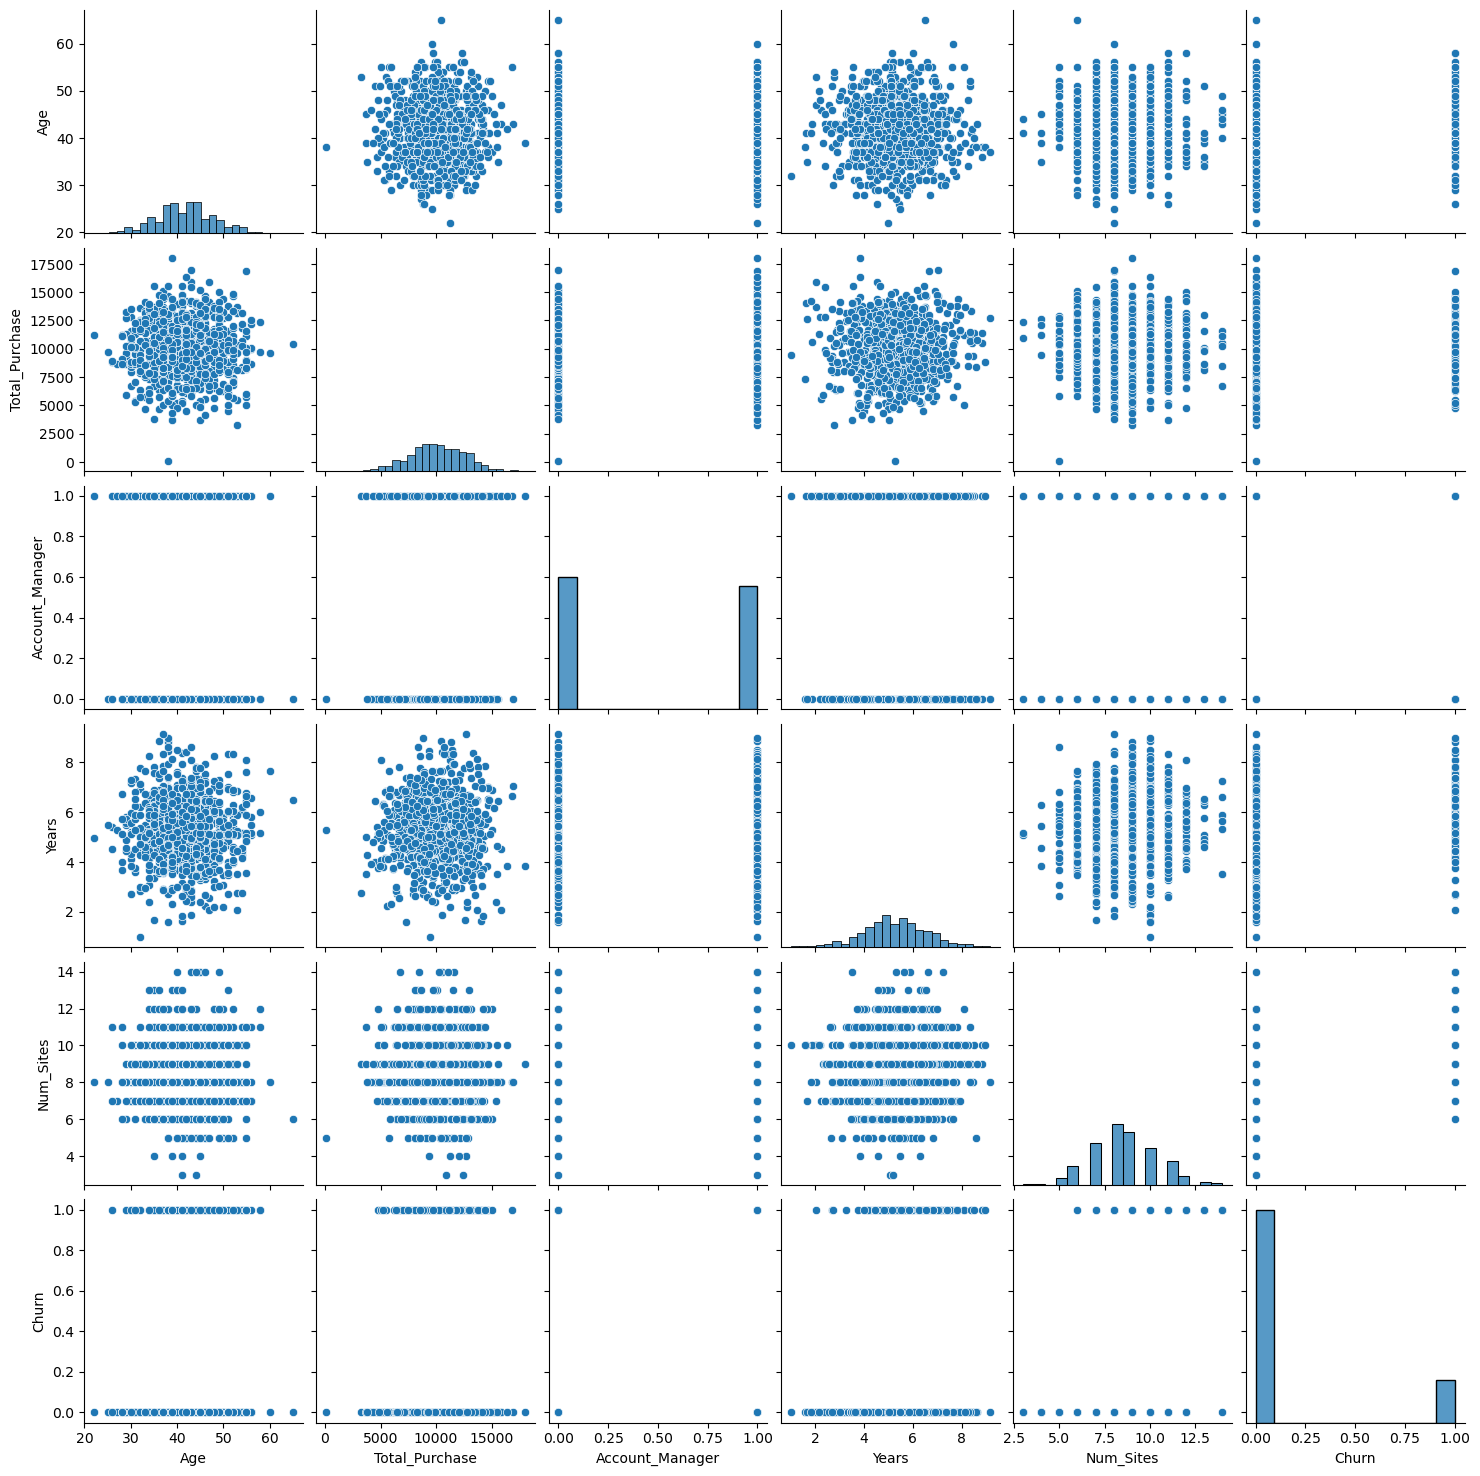

In [9]:
sns.pairplot(df)
plt.show()

In [150]:
df.groupby('Churn')[['Age', 'Total_Purchase', 'Account_Manager', 'Years',
       'Num_Sites']].agg(["mean", "median", "max", "min"])

Age                    Total_Purchase                       \
            mean median   max   min           mean     median       max   
Churn                                                                     
0      41.581333   41.0  65.0  22.0   10036.952853   9999.705  18026.01   
1      42.993333   43.0  58.0  26.0   10192.179933  10273.760  16838.94   

               Account_Manager                    Years                     \
           min            mean median max min      mean median   max   min   
Churn                                                                        
0       100.00        0.465333    0.0   1   0  5.151067   5.08  9.15  1.00   
1      4771.65        0.560000    1.0   1   0  5.883600   5.80  8.97  2.05   

       Num_Sites                    
            mean median   max  min  
Churn                               
0       8.173333    8.0  14.0  3.0  
1      10.660000   11.0  14.0  6.0

In [11]:
df.groupby('Account_Manager')[['Age', 'Total_Purchase', 'Churn', 'Years',
       'Num_Sites']].agg(["mean", "median", "max", "min"])

Age                    Total_Purchase            \
                      mean median   max   min           mean    median   
Account_Manager                                                          
0                41.903640   42.0  65.0  25.0   10026.070471  10041.13   
1                41.722864   41.0  60.0  22.0   10102.463557  10054.60   

                                      Churn                    Years         \
                      max     min      mean median max min      mean median   
Account_Manager                                                               
0                16955.76   100.0  0.141328    0.0   1   0  5.245032   5.16   
1                18026.01  3263.0  0.193995    0.0   1   0  5.303487   5.27   

                            Num_Sites                    
                  max   min      mean median   max  min  
Account_Manager                                          
0                9.15  1.58  8.531049    8.0  14.0  3.0  
1                8.97  1.00  8.648961    9.0  14.0  3.0

In [12]:
corr = df[['Age', 'Total_Purchase', 'Account_Manager', 'Years',
       'Num_Sites', 'Churn']].corr()

<Axes: >

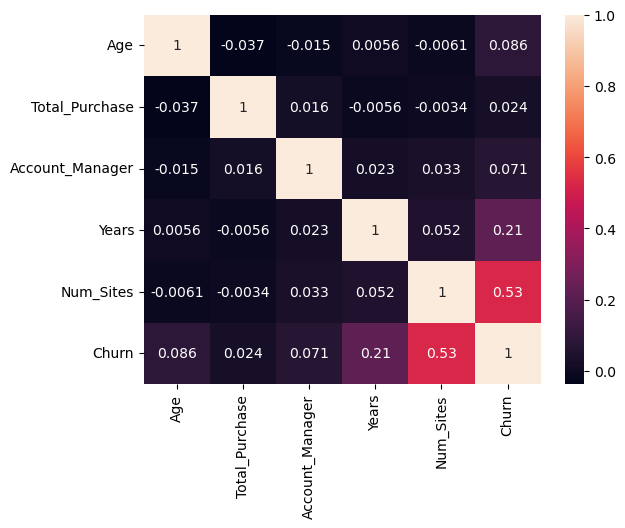

In [13]:
sns.heatmap(corr, annot= True)

In [14]:
# 피처 각각에 대한 히스토그램을 출력
def plot_hist(df):
    fig = plt.figure(figsize = (20, 16))

    # df의 열 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i + 1)
        plt.hist(df[df.columns[i]], bins = 50)
        ax.set_title(df.columns[i])

    plt.tight_layout()
    plt.show()

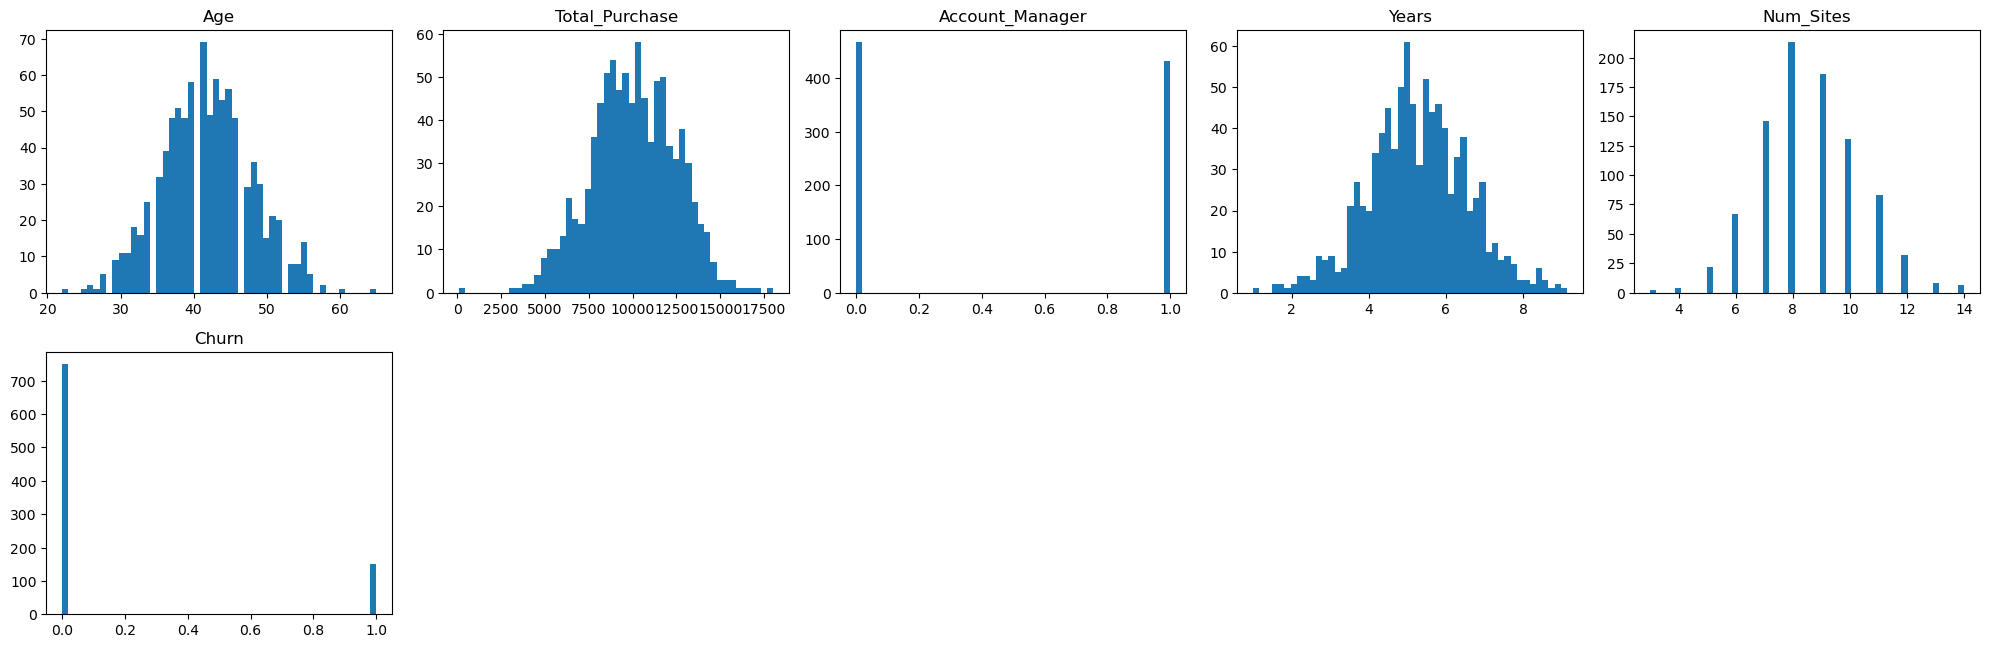

In [15]:
plot_hist(df[['Age', 'Total_Purchase', 'Account_Manager', 'Years',
       'Num_Sites', 'Churn']])

<hr>

### 머신러닝용 데이터 전처리

우리는 수치형 데이터만 이용할 예정입니다. Account_Manager는 다루기 어렵지 않기 때문에 모델학습에 포함할 수도 있겠지만 무작위로 할당된 것이기 때문에 큰 의미가 없을 수 있습니다.

# 언더샘플링, 로버스트 스케일링, 수치형 데이터 전부 사용

- roc_auc : 0.9266172839506174

In [107]:
x = df[['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites']]
y = df[['Churn']]

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 42)

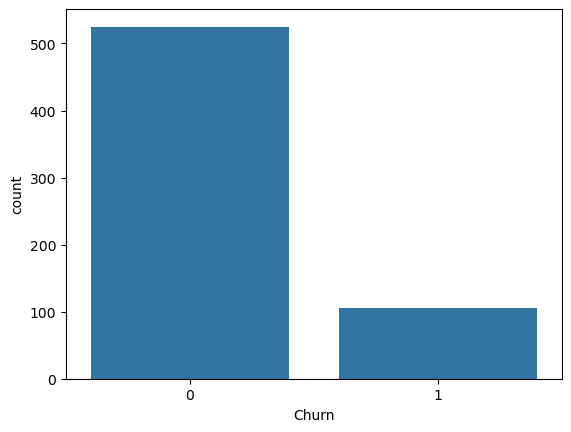

In [109]:
# 종속변수 클래스 분포 시각화
sns.countplot(x = "Churn", data = y_train)
plt.show()

In [110]:
x_train.shape

(630, 5)

In [111]:
# imblearn 사용을 위한 임시 변수명 적용
x_train_re = x_train.copy()
y_train_re = y_train.copy()

x_tmp_name = [f"X{i}" for i in range(1, 6)]
y_tmp_name = ["y1"]

x_train_re.columns = x_tmp_name
y_train_re.columns = y_tmp_name

In [112]:
x_train_under, y_train_under = RandomUnderSampler(random_state = 19).fit_resample(x_train_re, y_train_re)

In [113]:
print("언더샘플링 적용 후 레이블 값 분포", np.unique(y_train_under['y1'], return_counts = True))

언더샘플링 적용 후 레이블 값 분포 (array([0, 1], dtype=int64), array([105, 105], dtype=int64))


In [114]:
x_train_under.columns = x_train.columns
y_train_under.columns = y_train.columns

In [115]:
x_train_under.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites
290,42.0,12300.94,1,6.89,10.0
794,38.0,6574.25,0,6.18,9.0
510,34.0,8772.26,0,5.78,9.0
628,42.0,8558.52,0,5.36,7.0
587,38.0,9826.29,0,4.93,8.0


In [116]:
rs = RobustScaler()
scaled_train = rs.fit_transform(x_train_under)
scaled_test = rs.transform(x_test)

In [117]:
logi = LogisticRegression()
logi.fit(scaled_train, y_train_under)

C:\Users\xdbsq\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [118]:
pred = logi.predict(scaled_test)

In [119]:
logi.score(scaled_test,y_test)

0.8851851851851852

In [120]:
print(confusion_matrix(y_test, pred))

[[200  25]
 [  6  39]]


In [121]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       225
           1       0.61      0.87      0.72        45

    accuracy                           0.89       270
   macro avg       0.79      0.88      0.82       270
weighted avg       0.91      0.89      0.89       270



In [31]:
pred_proba = logi.predict_proba(scaled_test)[:,1]

In [32]:
print(roc_auc_score(y_test, pred_proba))

0.9266172839506174


<hr>

# Account_Manager 제거, 스탠다드 스케일링

- roc_auc : 0.9281975308641977

In [33]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [34]:
x1 = df[['Age', 'Total_Purchase', 'Years', 'Num_Sites']]
y1 = df['Churn']

In [35]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.3, stratify = y1, random_state = 42)

In [36]:
ss1 = StandardScaler()
scaled_train1 = ss1.fit_transform(x_train1)
scaled_test1 = ss1.transform(x_test1)

In [37]:
logi1 = LogisticRegression()
logi1.fit(scaled_train1, y_train1)

LogisticRegression()

In [38]:
pred1 = logi1.predict(scaled_test1)
roc_auc_score(y_test1, pred1)

0.788888888888889

In [39]:
pred_proba1 = logi1.predict_proba(scaled_test1)[:,1]
roc_auc_score(y_test1, pred_proba1)

0.9281975308641977

In [40]:
print(confusion_matrix(y_test1, pred1))

[[220   5]
 [ 18  27]]


In [41]:
print(classification_report(y_test1, pred1))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       225
           1       0.84      0.60      0.70        45

    accuracy                           0.91       270
   macro avg       0.88      0.79      0.83       270
weighted avg       0.91      0.91      0.91       270



<hr>

# year 추가, ss

- roc_auc : 0.9275061728395062

In [42]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [43]:
df1 = df.copy()

In [44]:
df1["Onboard_year"] = df1["Onboard_date"].dt.year

In [45]:
df1.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn,Onboard_year
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1,2016
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1,2014
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1,2016


In [46]:
x2 = df1[["Age", "Total_Purchase","Account_Manager", "Years", "Num_Sites", "Onboard_year"]]
y2 = df1["Churn"]

In [47]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.3, stratify = y2, random_state = 42)

In [48]:
ss2 = StandardScaler()
scaled_train2 = ss2.fit_transform(x_train2)
scaled_test2 = ss2.transform(x_test2)

In [49]:
logi2 = LogisticRegression()
logi2.fit(scaled_train2, y_train2)

LogisticRegression()

In [50]:
pred2 = logi2.predict(scaled_test2)
roc_auc_score(y_test2, pred2)

0.7422222222222222

In [51]:
pred_proba2 = logi2.predict_proba(scaled_test2)[:,1]
roc_auc_score(y_test2, pred_proba2)

0.9275061728395062

In [52]:
print(confusion_matrix(y_test2, pred2))

[[219   6]
 [ 22  23]]


In [53]:
print(classification_report(y_test2, pred2))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       225
           1       0.79      0.51      0.62        45

    accuracy                           0.90       270
   macro avg       0.85      0.74      0.78       270
weighted avg       0.89      0.90      0.89       270



<hr>

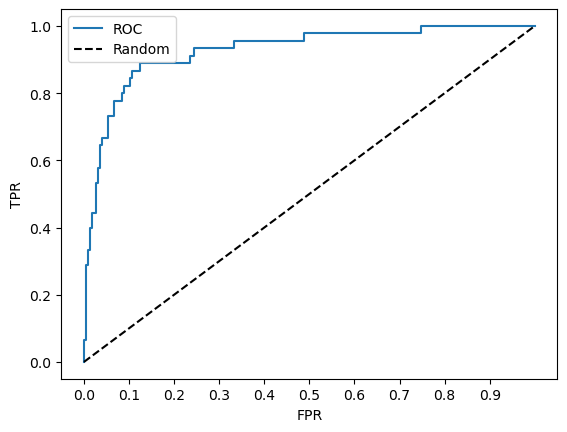

In [154]:
pred_proba_class1 = logi.predict_proba(scaled_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

plt.figure()
plt.plot(fprs, tprs, label = "ROC")
plt.plot([0, 1], [0, 1], "k--", label = "Random")

plt.xticks(np.round(np.arange(0, 1, 0.1), 2))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(0, 1)

plt.show()

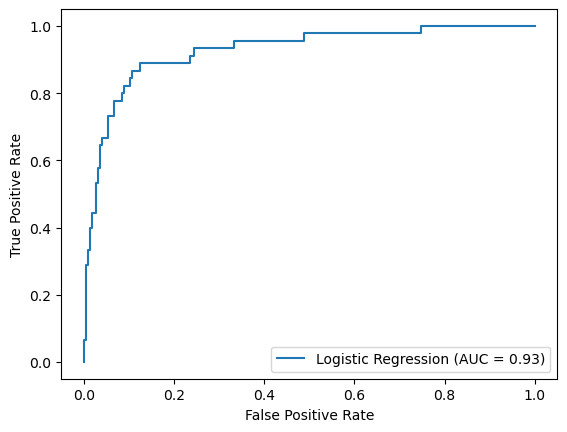

In [153]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name="Logistic Regression")
display.plot()